#Loading and Pre-Processing the Data

Upload cv_train, cv_test, sample_submission and the images folder to your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Loading the necessary libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold,KFold

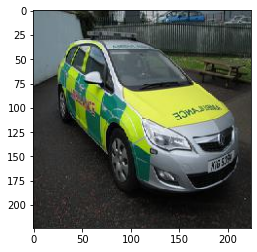

In [ ]:
# Check whether images are loading properly
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
image1 = read_image('/content/gdrive/My Drive/images/0.jpg')
plt.imshow(image1)

In [ ]:
training_data=pd.read_csv('/content/gdrive/My Drive/cv_train.csv')
testing_data=pd.read_csv('/content/gdrive/My Drive/cv_test.csv')
def prep(img_name):
    img_name=img_name.split(".")[0]
    img_name=str(img_name)
    return img_name
training_data["image_no"]=training_data["image_names"].copy().apply(prep)
training_data["emergency_or_not"]=training_data["emergency_or_not"].astype(str)
testing_data["image_no"]=testing_data["image_names"].copy().apply(prep)

In [ ]:
folder_path = '/content/gdrive/My Drive/images'
testing_images=[]
preds=[]
for i in range(0,len(testing_data)):
    img = os.path.join(folder_path,testing_data.iloc[i,0])
    img = image.load_img(img, target_size=(299,299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    testing_images.append(img)
testing_images = np.vstack(testing_images)

In [ ]:
# K fold Cross Validation
K = 5
kf = KFold(n_splits = K, random_state = 42, shuffle = True)
skf = StratifiedKFold(n_splits = K, random_state = 7, shuffle = True)
MAX_ROUNDS = 1000
OPTIMIZE_ROUNDS = False
df_x_train=training_data["image_names"]
df_y_train=training_data["emergency_or_not"]

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,)
datagen1= ImageDataGenerator(rescale = 1./255)

#Basic CNN

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(299,299,3)),
  tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
  tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(299, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
# This combination of layers currently gives the best training and testing accuracy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 297, 297, 64)      1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 295, 295, 32)      18464     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 293, 293, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 146, 146, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 682112)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 299)               203951787 
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
y_valid_pred = 0*df_y_train
y_test_pred = 0
accuracy = 0
result={}
j=1

for train_index, test_index in skf.split(df_x_train, df_y_train):  
    # Create data for this fold
    x_train=datagen.flow_from_dataframe(dataframe=training_data.iloc[train_index,:],
                                                directory="/content/gdrive/My Drive/images",
                                                x_col="image_names",
                                                y_col="emergency_or_not",
                                                weight_col=None,
                                                target_size=(299, 299),
                                                color_mode="rgb",
                                                class_mode="binary",
                                                batch_size=32)
    
    x_valid=datagen1.flow_from_dataframe(dataframe=training_data.iloc[test_index,:],
                                                directory="/content/gdrive/My Drive/images",
                                                x_col="image_names",
                                                y_col="emergency_or_not",
                                                weight_col=None,
                                                target_size=(299, 299),
                                                color_mode="rgb",
                                                class_mode="binary",
                                                batch_size=32)
    print( "\nFold ", j)
    model.fit_generator(x_train,epochs=5,validation_data=x_valid)
    # Accumulate test set predictions
    y_test_pred += model.predict_classes(testing_images,batch_size=32)
    result[j]=model.predict_classes(testing_images,batch_size=32)
    j+=1
results = y_test_pred / K  # Average of k predictions

Found 1316 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.

Fold  1


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 29s 688ms/step - loss: 2.0918 - accuracy: 0.5775 - val_loss: 0.6853 - val_accuracy: 0.6667
Epoch 2/5
42/42 [==============================] - 28s 677ms/step - loss: 0.6770 - accuracy: 0.6596 - val_loss: 0.6449 - val_accuracy: 0.6909
Epoch 3/5
42/42 [==============================] - 29s 680ms/step - loss: 0.6402 - accuracy: 0.6809 - val_loss: 0.7302 - val_accuracy: 0.6576
Epoch 4/5
42/42 [==============================] - 28s 677ms/step - loss: 0.5715 - accuracy: 0.7249 - val_loss: 0.5089 - val_accuracy: 0.7576
Epoch 5/5
42/42 [==============================] - 29s 680ms/step - loss: 0.4930 - accuracy: 0.7720 - val_loss: 0.5440 - val_accuracy: 0.7667
Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.

Fold  2


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 29s 682ms/step - loss: 0.5109 - accuracy: 0.7661 - val_loss: 0.4673 - val_accuracy: 0.8024
Epoch 2/5
42/42 [==============================] - 29s 682ms/step - loss: 0.4777 - accuracy: 0.7851 - val_loss: 0.5041 - val_accuracy: 0.8146
Epoch 3/5
42/42 [==============================] - 28s 678ms/step - loss: 0.4539 - accuracy: 0.8003 - val_loss: 0.5218 - val_accuracy: 0.7568
Epoch 4/5
42/42 [==============================] - 28s 677ms/step - loss: 0.4279 - accuracy: 0.8049 - val_loss: 0.4830 - val_accuracy: 0.7812
Epoch 5/5
42/42 [==============================] - 28s 676ms/step - loss: 0.3794 - accuracy: 0.8223 - val_loss: 0.5642 - val_accuracy: 0.7720
Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.

Fold  3


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 29s 688ms/step - loss: 0.4000 - accuracy: 0.8261 - val_loss: 0.3768 - val_accuracy: 0.8450
Epoch 2/5
42/42 [==============================] - 28s 677ms/step - loss: 0.3626 - accuracy: 0.8474 - val_loss: 0.3708 - val_accuracy: 0.8511
Epoch 3/5
42/42 [==============================] - 28s 677ms/step - loss: 0.3587 - accuracy: 0.8322 - val_loss: 0.4030 - val_accuracy: 0.8389
Epoch 4/5
42/42 [==============================] - 28s 676ms/step - loss: 0.3518 - accuracy: 0.8474 - val_loss: 0.3155 - val_accuracy: 0.8511
Epoch 5/5
42/42 [==============================] - 28s 677ms/step - loss: 0.3428 - accuracy: 0.8550 - val_loss: 0.3022 - val_accuracy: 0.8602
Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.

Fold  4


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 29s 682ms/step - loss: 0.3333 - accuracy: 0.8580 - val_loss: 0.2715 - val_accuracy: 0.9027
Epoch 2/5
42/42 [==============================] - 29s 681ms/step - loss: 0.3239 - accuracy: 0.8664 - val_loss: 0.3601 - val_accuracy: 0.8663
Epoch 3/5
42/42 [==============================] - 29s 680ms/step - loss: 0.3283 - accuracy: 0.8550 - val_loss: 0.3054 - val_accuracy: 0.8967
Epoch 4/5
42/42 [==============================] - 29s 681ms/step - loss: 0.2798 - accuracy: 0.8884 - val_loss: 0.3168 - val_accuracy: 0.8784
Epoch 5/5
42/42 [==============================] - 28s 677ms/step - loss: 0.3006 - accuracy: 0.8694 - val_loss: 0.3730 - val_accuracy: 0.8571
Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.

Fold  5


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 29s 686ms/step - loss: 0.3045 - accuracy: 0.8762 - val_loss: 0.2205 - val_accuracy: 0.9058
Epoch 2/5
42/42 [==============================] - 29s 679ms/step - loss: 0.2815 - accuracy: 0.8914 - val_loss: 0.2327 - val_accuracy: 0.9027
Epoch 3/5
42/42 [==============================] - 28s 677ms/step - loss: 0.2480 - accuracy: 0.9058 - val_loss: 0.2064 - val_accuracy: 0.8997
Epoch 4/5
42/42 [==============================] - 28s 675ms/step - loss: 0.2339 - accuracy: 0.9066 - val_loss: 0.2472 - val_accuracy: 0.8967
Epoch 5/5
42/42 [==============================] - 28s 678ms/step - loss: 0.2374 - accuracy: 0.9066 - val_loss: 0.2719 - val_accuracy: 0.9088


In [ ]:
#submissions
from google.colab import files
for i in range(1,6):
  submission = pd.read_csv("/content/gdrive/My Drive/sample_submission.csv")
  submission["emergency_or_not"] = result[i].astype(int)
  submission.to_csv("submission_1."+str(i)+".csv",index_label = False)
  files.download("submission_1."+str(i)+".csv")
# average of k folds
submission = pd.read_csv("/content/gdrive/My Drive/sample_submission.csv")
submission["emergency_or_not"] = results.astype(int)
submission.to_csv("submission_1.6.csv",index_label = False)
files.download("submission_1.6.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Transfer Learning using Pre-Trained Model: ResNet152V2

In [ ]:
# Create the base model from the pre-trained model ResNet152V2
IMG_SHAPE = (299,299, 3)
new_base_model = tf.keras.applications.ResNet152V2(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
new_base_model.trainable = False
new_base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [ ]:
model = tf.keras.Sequential([
  new_base_model,
  tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
  tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
# This combination of layers currently gives the best training and testing accuracy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 10, 10, 2048)      58331648  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         2359424   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)         147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               295168    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
y_valid_pred = 0*df_y_train
y_test_pred = 0
accuracy = 0
result={}
j=1

for train_index, test_index in skf.split(df_x_train, df_y_train):  
    # Create data for this fold
    x_train=datagen.flow_from_dataframe(dataframe=training_data.iloc[train_index,:],
                                                directory="/content/gdrive/My Drive/images",
                                                x_col="image_names",
                                                y_col="emergency_or_not",
                                                weight_col=None,
                                                target_size=(299,299),
                                                color_mode="rgb",
                                                class_mode="binary",
                                                batch_size=32)
    
    x_valid=datagen1.flow_from_dataframe(dataframe=training_data.iloc[test_index,:],
                                                directory="/content/gdrive/My Drive/images",
                                                x_col="image_names",
                                                y_col="emergency_or_not",
                                                weight_col=None,
                                                target_size=(299,299),
                                                color_mode="rgb",
                                                class_mode="binary",
                                                batch_size=32)
    print( "\nFold ", j)
    model.fit_generator(x_train,epochs=5,validation_data=x_valid)
    # Accumulate test set predictions
    y_test_pred += model.predict_classes(testing_images,batch_size=32)
    result[j]=model.predict_classes(testing_images,batch_size=32)
    j+=1
results = y_test_pred / K  # Average of k predictions

Found 1316 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.

Fold  1
Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 778s 19s/step - loss: 0.6047 - accuracy: 0.8837 - val_loss: 0.1695 - val_accuracy: 0.9424
Epoch 2/5
42/42 [==============================] - 28s 669ms/step - loss: 0.1335 - accuracy: 0.9529 - val_loss: 0.1285 - val_accuracy: 0.9424
Epoch 3/5
42/42 [==============================] - 28s 670ms/step - loss: 0.1129 - accuracy: 0.9643 - val_loss: 0.1636 - val_accuracy: 0.9576
Epoch 4/5
42/42 [==============================] - 28s 668ms/step - loss: 0.1113 - accuracy: 0.9582 - val_loss: 0.3006 - val_accuracy: 0.9303
Epoch 5/5
42/42 [==============================] - 28s 666ms/step - loss: 0.0956 - accuracy: 0.9696 - val_loss: 0.2515 - val_accuracy: 0.9333
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if i

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 29s 689ms/step - loss: 0.0938 - accuracy: 0.9643 - val_loss: 0.0558 - val_accuracy: 0.9757
Epoch 2/5
42/42 [==============================] - 28s 668ms/step - loss: 0.0937 - accuracy: 0.9689 - val_loss: 0.0725 - val_accuracy: 0.9757
Epoch 3/5
42/42 [==============================] - 28s 674ms/step - loss: 0.0591 - accuracy: 0.9818 - val_loss: 0.0713 - val_accuracy: 0.9666
Epoch 4/5
42/42 [==============================] - 28s 671ms/step - loss: 0.0348 - accuracy: 0.9856 - val_loss: 0.0965 - val_accuracy: 0.9666
Epoch 5/5
42/42 [==============================] - 28s 674ms/step - loss: 0.0565 - accuracy: 0.9787 - val_loss: 0.0716 - val_accuracy: 0.9757
Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.

Fold  3


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 28s 673ms/step - loss: 0.0756 - accuracy: 0.9765 - val_loss: 0.0461 - val_accuracy: 0.9818
Epoch 2/5
42/42 [==============================] - 28s 670ms/step - loss: 0.0364 - accuracy: 0.9848 - val_loss: 0.0696 - val_accuracy: 0.9818
Epoch 3/5
42/42 [==============================] - 28s 670ms/step - loss: 0.0345 - accuracy: 0.9886 - val_loss: 0.0493 - val_accuracy: 0.9848
Epoch 4/5
42/42 [==============================] - 28s 669ms/step - loss: 0.0291 - accuracy: 0.9909 - val_loss: 0.0440 - val_accuracy: 0.9787
Epoch 5/5
42/42 [==============================] - 28s 670ms/step - loss: 0.0294 - accuracy: 0.9894 - val_loss: 0.0260 - val_accuracy: 0.9878
Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.

Fold  4


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 28s 676ms/step - loss: 0.0276 - accuracy: 0.9901 - val_loss: 0.0118 - val_accuracy: 0.9970
Epoch 2/5
42/42 [==============================] - 28s 671ms/step - loss: 0.0302 - accuracy: 0.9909 - val_loss: 0.0149 - val_accuracy: 0.9939
Epoch 3/5
42/42 [==============================] - 28s 672ms/step - loss: 0.0247 - accuracy: 0.9909 - val_loss: 0.0048 - val_accuracy: 0.9970
Epoch 4/5
42/42 [==============================] - 28s 673ms/step - loss: 0.0271 - accuracy: 0.9901 - val_loss: 0.0295 - val_accuracy: 0.9909
Epoch 5/5
42/42 [==============================] - 28s 676ms/step - loss: 0.0368 - accuracy: 0.9894 - val_loss: 0.0030 - val_accuracy: 1.0000
Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.

Fold  5


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 29s 680ms/step - loss: 0.0213 - accuracy: 0.9901 - val_loss: 0.0044 - val_accuracy: 0.9970
Epoch 2/5
42/42 [==============================] - 28s 674ms/step - loss: 0.0287 - accuracy: 0.9886 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 3/5
42/42 [==============================] - 28s 678ms/step - loss: 0.0213 - accuracy: 0.9886 - val_loss: 0.0115 - val_accuracy: 0.9939
Epoch 4/5
42/42 [==============================] - 29s 679ms/step - loss: 0.0173 - accuracy: 0.9939 - val_loss: 0.0103 - val_accuracy: 0.9939
Epoch 5/5
42/42 [==============================] - 28s 676ms/step - loss: 0.0103 - accuracy: 0.9977 - val_loss: 0.0364 - val_accuracy: 0.9878


In [ ]:
from google.colab import files
for i in range(1,6):
  submission = pd.read_csv("/content/gdrive/My Drive/sample_submission.csv")
  submission["emergency_or_not"] = result[i].astype(int)
  submission.to_csv("submission_3."+str(i)+".csv",index_label = False)
  files.download("submission_3."+str(i)+".csv")
# average of k folds
submission = pd.read_csv("/content/gdrive/My Drive/sample_submission.csv")
submission["emergency_or_not"] = results.astype(int)
submission.to_csv("submission_3.6.csv",index_label = False)
files.download("submission_3.6.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Transfer Learning using Pre-Trained Model: InceptionResNetV2


In [ ]:
# Create the base model from the pre-trained model InceptionResNetV2
IMG_SHAPE = (299,299, 3)
new_base_model = tf.keras.applications.InceptionResNetV2(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
new_base_model.trainable = False
new_base_model.summary()

219062272/219055592 [==============================] - 4s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________

In [ ]:
model = tf.keras.Sequential([
  new_base_model,
  tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'),
  tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
# This combination of layers currently gives the best training and testing accuracy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
conv2d_207 (Conv2D)          (None, 6, 6, 256)         3539200   
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 4, 4, 128)         295040    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
y_valid_pred = 0*df_y_train
y_test_pred = 0
accuracy = 0
result={}
j=1

for train_index, test_index in skf.split(df_x_train, df_y_train):  
    # Create data for this fold
    x_train=datagen.flow_from_dataframe(dataframe=training_data.iloc[train_index,:],
                                                directory="/content/gdrive/My Drive/images",
                                                x_col="image_names",
                                                y_col="emergency_or_not",
                                                weight_col=None,
                                                target_size=(299,299),
                                                color_mode="rgb",
                                                class_mode="binary",
                                                batch_size=32)
    
    x_valid=datagen1.flow_from_dataframe(dataframe=training_data.iloc[test_index,:],
                                                directory="/content/gdrive/My Drive/images",
                                                x_col="image_names",
                                                y_col="emergency_or_not",
                                                weight_col=None,
                                                target_size=(299,299),
                                                color_mode="rgb",
                                                class_mode="binary",
                                                batch_size=32)
    print( "\nFold ", j)
    model.fit_generator(x_train,epochs=5,validation_data=x_valid)
    # Accumulate test set predictions
    y_test_pred += model.predict_classes(testing_images,batch_size=32)
    result[j]=model.predict_classes(testing_images,batch_size=32)
    j+=1
results = y_test_pred / K  # Average of k predictions

Found 1316 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.

Fold  1


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 31s 744ms/step - loss: 0.7365 - accuracy: 0.8374 - val_loss: 0.1631 - val_accuracy: 0.9485
Epoch 2/5
42/42 [==============================] - 28s 659ms/step - loss: 0.1446 - accuracy: 0.9483 - val_loss: 0.1872 - val_accuracy: 0.9545
Epoch 3/5
42/42 [==============================] - 27s 652ms/step - loss: 0.1280 - accuracy: 0.9498 - val_loss: 0.1439 - val_accuracy: 0.9545
Epoch 4/5
42/42 [==============================] - 27s 653ms/step - loss: 0.0998 - accuracy: 0.9597 - val_loss: 0.1702 - val_accuracy: 0.9515
Epoch 5/5
42/42 [==============================] - 27s 650ms/step - loss: 0.1034 - accuracy: 0.9681 - val_loss: 0.1588 - val_accuracy: 0.9515
Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.

Fold  2


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 28s 670ms/step - loss: 0.1155 - accuracy: 0.9605 - val_loss: 0.0927 - val_accuracy: 0.9605
Epoch 2/5
42/42 [==============================] - 27s 650ms/step - loss: 0.1039 - accuracy: 0.9582 - val_loss: 0.0842 - val_accuracy: 0.9726
Epoch 3/5
42/42 [==============================] - 27s 649ms/step - loss: 0.0756 - accuracy: 0.9704 - val_loss: 0.1272 - val_accuracy: 0.9514
Epoch 4/5
42/42 [==============================] - 28s 662ms/step - loss: 0.1118 - accuracy: 0.9613 - val_loss: 0.0990 - val_accuracy: 0.9514
Epoch 5/5
42/42 [==============================] - 27s 649ms/step - loss: 0.0957 - accuracy: 0.9704 - val_loss: 0.2353 - val_accuracy: 0.9210
Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.

Fold  3


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 28s 655ms/step - loss: 0.1026 - accuracy: 0.9658 - val_loss: 0.0552 - val_accuracy: 0.9787
Epoch 2/5
42/42 [==============================] - 28s 656ms/step - loss: 0.0719 - accuracy: 0.9757 - val_loss: 0.1076 - val_accuracy: 0.9544
Epoch 3/5
42/42 [==============================] - 27s 651ms/step - loss: 0.0676 - accuracy: 0.9765 - val_loss: 0.0637 - val_accuracy: 0.9726
Epoch 4/5
42/42 [==============================] - 27s 653ms/step - loss: 0.0537 - accuracy: 0.9810 - val_loss: 0.0578 - val_accuracy: 0.9787
Epoch 5/5
42/42 [==============================] - 27s 650ms/step - loss: 0.0498 - accuracy: 0.9841 - val_loss: 0.0558 - val_accuracy: 0.9787
Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.

Fold  4


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 27s 654ms/step - loss: 0.0566 - accuracy: 0.9810 - val_loss: 0.0650 - val_accuracy: 0.9757
Epoch 2/5
42/42 [==============================] - 28s 656ms/step - loss: 0.0758 - accuracy: 0.9696 - val_loss: 0.0260 - val_accuracy: 0.9878
Epoch 3/5
42/42 [==============================] - 27s 649ms/step - loss: 0.0599 - accuracy: 0.9772 - val_loss: 0.0531 - val_accuracy: 0.9787
Epoch 4/5
42/42 [==============================] - 28s 660ms/step - loss: 0.0462 - accuracy: 0.9818 - val_loss: 0.1574 - val_accuracy: 0.9544
Epoch 5/5
42/42 [==============================] - 27s 654ms/step - loss: 0.0538 - accuracy: 0.9795 - val_loss: 0.0463 - val_accuracy: 0.9787


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
42/42 [==============================] - 27s 651ms/step - loss: 0.0623 - accuracy: 0.9825 - val_loss: 0.0467 - val_accuracy: 0.9848
Epoch 2/5
42/42 [==============================] - 27s 653ms/step - loss: 0.0373 - accuracy: 0.9863 - val_loss: 0.0408 - val_accuracy: 0.9878
Epoch 3/5
42/42 [==============================] - 27s 649ms/step - loss: 0.0230 - accuracy: 0.9947 - val_loss: 0.0342 - val_accuracy: 0.9878
Epoch 4/5
42/42 [==============================] - 27s 649ms/step - loss: 0.0359 - accuracy: 0.9856 - val_loss: 0.0454 - val_accuracy: 0.9818
Epoch 5/5
42/42 [==============================] - 27s 652ms/step - loss: 0.0622 - accuracy: 0.9818 - val_loss: 0.0591 - val_accuracy: 0.9787


In [ ]:
from google.colab import files
for i in range(1,6):
  submission = pd.read_csv("/content/gdrive/My Drive/sample_submission.csv")
  submission["emergency_or_not"] = result[i].astype(int)
  submission.to_csv("submission_2."+str(i)+".csv",index_label = False)
  files.download("submission_2."+str(i)+".csv")
# average of k folds
submission = pd.read_csv("/content/gdrive/My Drive/sample_submission.csv")
submission["emergency_or_not"] = results.astype(int)
submission.to_csv("submission_2.6.csv",index_label = False)
files.download("submission_2.6.csv")